# Wieloboki Voronoi'a

In [1]:
import numpy as np
from visualizer.main import Visualizer

**Klasy**


In [2]:
from utils import Point, Edge, HalfLine, Triangle

**Funkcje pomocnicze**

In [3]:
from utils import obtuseAngle

**Narzędzia do wizualizacji**

In [4]:
def draw_tri(triangleList):
    vis = Visualizer()
    points = set()
    sides = set()
    for triangle in triangleList:
        a = (triangle.a.x, triangle.a.y)
        b = (triangle.b.x, triangle.b.y)
        c = (triangle.c.x, triangle.c.y)
        points.add(a)
        points.add(b)
        points.add(c)
        sides.add((a, b))
        sides.add((b, c))
        sides.add((c, a))
        
    

    vis.add_point(list(points), color='black')
    vis.add_line_segment(list(sides), color='black')
    vis.show()

def draw_voronoi(triangleList, voronoiDiagram):
    vis = Visualizer()
    points = set()
    sides = set()
    edgeList = {}

    for triangle in triangleList:
        a = triangle.a
        b = triangle.b
        c = triangle.c
        edgeAB = Edge(a, b)
        edgeBC = Edge(b, c)
        edgeCA = Edge(c, a)
        points.add(a.toCart())
        points.add(b.toCart())
        points.add(c.toCart())
        sides.add(edgeAB.toCart())
        sides.add(edgeBC.toCart())
        sides.add(edgeCA.toCart())
        for edge in [edgeAB, edgeBC, edgeCA]:
            if edge in edgeList.keys():
                edgeList[edge].add(triangle)
            else:
                edgeList[edge] = set()
                edgeList[edge].add(triangle)

    for object in voronoiDiagram:
        if isinstance(object, Point):
             vis.add_point(object.toCart(), color='red')
        elif isinstance(object, Edge):
            vis.add_line_segment(object.toCart(), color='red')
        elif isinstance(object, HalfLine):
            vis.add_half_line(object.toCart(),color='red')
                    
        
            
            
    vis.add_point(list(points), color='black')
    vis.add_line_segment(list(sides), color='black')
    vis.show()

**Zbiory danych**

In [5]:
def generate_uniform_points(left, right, n = 10 ** 5):
    tab =[]
    for _ in range(n):
        x = np.random.uniform(left, right)
        y = np.random.uniform(left, right)
        tab.append((x, y))
    return tab

**Wizualizacja działania algorytmu**

In [6]:
def Bowyer_Watson_with_vis(points):
    lowerX = points[0][0]
    lowerY = points[0][1]
    upperX = points[0][0]
    upperY = points[0][1]
    pointList = []
    n = len(points)
    for i in range(n):
        newPoint = Point(points[i], i)
        pointList.append(newPoint)
        if points[i][0]<lowerX: lowerX = points[i][0]
        if points[i][1]<lowerY: lowerY = points[i][1]
        if points[i][0]>upperX: upperX = points[i][0]
        if points[i][1]>upperY: upperY = points[i][1]


    vis = Visualizer()
    triangleList = []
    # Prostokąt
    lowerX-=100
    lowerY-=100
    upperX+=100
    upperY+=100
    superA = Point((lowerX, lowerY), -2)
    superB = Point((lowerX, upperY), -3)
    superC = Point((upperX, upperY), -4)
    superD = Point((upperX, lowerY), -5)
    vis.add_point([superA.toCart(),superB.toCart(),superC.toCart(),superD.toCart()],color='green')
    # Dwa trójkąty
    superTriangle1 = Triangle(superA, superB, superC)
    superTriangle2 = Triangle(superC, superD, superA)
    triangleList.append(superTriangle1)
    triangleList.append(superTriangle2)

    # Główna pętla algorytmu
    for point in pointList:
        vis.add_point(point.toCart(),color='black')
        #vis.show()
        # klucz: krawedz, wartość: zbiór trójkątów
        edgeList = {}
        to_delete = []

        to_draw = []
        for triangle in triangleList:
            a = triangle.a
            b = triangle.b
            c = triangle.c
            to_draw+=[(a.toCart(), b.toCart()), (b.toCart(), c.toCart()), (c.toCart(), a.toCart())]
        to_delete.append(vis.add_line_segment(to_draw,color='black')) 

        to_draw = []
        # Wyznaczenie trójkątów do usunięcia
        for triangle in triangleList:
            if triangle.circumcircleContainsPoint(point):
                triangle.isCorrect=False
                a = triangle.a
                b = triangle.b
                c = triangle.c
                edgeAB = Edge(a, b)
                edgeBC = Edge(b, c)
                edgeCA = Edge(c, a)
                if edgeAB in edgeList.keys():
                    edgeList[edgeAB].add(triangle)
                else:
                    edgeList[edgeAB] = set()
                    edgeList[edgeAB].add(triangle)
                if edgeBC in edgeList.keys():
                    edgeList[edgeBC].add(triangle)
                else:
                    edgeList[edgeBC] = set()
                    edgeList[edgeBC].add(triangle)
                if edgeCA in edgeList.keys():
                    edgeList[edgeCA].add(triangle)
                else:
                    edgeList[edgeCA] = set()
                    edgeList[edgeCA].add(triangle)
                to_draw+=[edgeAB.toCart(), edgeBC.toCart(), edgeCA.toCart()]
        ls = vis.add_line_segment(to_draw, color='red')
        vis.remove_figure(ls)

        # Usunięcie nieprawidłowych trójkątów
        newTriangleList = []
        for triangle in triangleList:
            if triangle.isCorrect==True: newTriangleList.append(triangle)

        triangleList = newTriangleList
  
        # Usunięcie przecinających się krawędzi
        newEdgeList = dict(edgeList)
        for edge in edgeList.keys():
            if len(edgeList[edge])>1:
                newEdgeList.pop(edge)
        edgeList = newEdgeList
        #ls = vis.add_line_segment(newEdgeList.keys(), color='purple')

        # Utworzenie nowych trójkątów - wypełnienie pustego wielokąta
        for edge in edgeList:
            triangle = Triangle(edge.A, edge.B, point)
            triangleList.append(triangle)

        for fig in to_delete:
            vis.remove_figure(fig)

    finalTriangleList = list(triangleList)
    # Usunięcie trójkątów zawierających sztuczne punkty początkowe
    for triangle in triangleList:
        if triangle.containsPoint(superA) or triangle.containsPoint(superB) or triangle.containsPoint(superC) or triangle.containsPoint(superD):
            finalTriangleList.remove(triangle)
    
    # Zwracanie reprezentacji wieloboków Voronoi
    triangleList = finalTriangleList
    voronoiDiagram = []
    edgeList = {}

    for triangle in triangleList:
        a = triangle.a
        b = triangle.b
        c = triangle.c
        edgeAB = Edge(a, b)
        edgeBC = Edge(b, c)
        edgeCA = Edge(c, a)
        for edge in [edgeAB, edgeBC, edgeCA]:
            if edge in edgeList.keys():
                edgeList[edge].add(triangle)
            else:
                edgeList[edge] = set()
                edgeList[edge].add(triangle)

    for triangle in triangleList:
        a = triangle.a
        b = triangle.b
        c = triangle.c
        edgeAB = Edge(a, b)
        edgeBC = Edge(b, c)
        edgeCA = Edge(c, a)
        voronoiPoint = triangle.getCircleCenter()
        voronoiDiagram.append(voronoiPoint)
        for edge in [edgeAB, edgeBC, edgeCA]:
            if len(edgeList[edge])>1:
                for otherTriangle in edgeList[edge]:
                    if otherTriangle!=triangle:
                        voronoiDiagram.append(Edge(voronoiPoint, otherTriangle.getCircleCenter()))
            else:
                middle = Point(((edge.A.x+edge.B.x)/2, (edge.A.y+edge.B.y)/2),-2)
                MV = (voronoiPoint.toCart()[0]-middle.toCart()[0], voronoiPoint.toCart()[1]-middle.toCart()[1])
                if obtuseAngle(triangle, edge):
                    newPoint = Point((voronoiPoint.toCart()[0]+MV[0], voronoiPoint.toCart()[1]+MV[1]),-2)
                    voronoiDiagram.append(HalfLine(voronoiPoint, newPoint))
                else:
                    voronoiDiagram.append(HalfLine(voronoiPoint,middle))

    return vis, finalTriangleList, voronoiDiagram

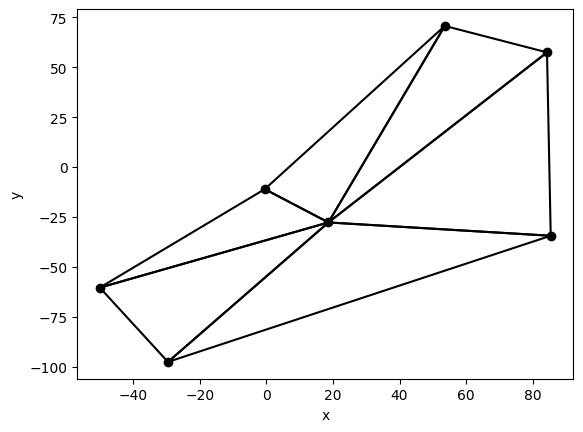

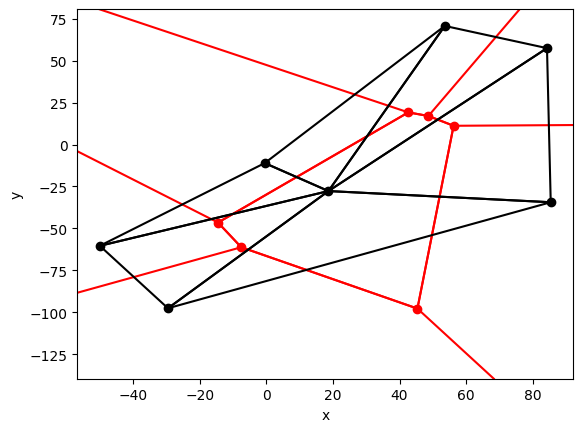

In [11]:
randomPoints = generate_uniform_points(-100, 100, 7)
vis, triangulation, voronoiDiagram = Bowyer_Watson_with_vis(randomPoints)
draw_tri(triangulation)
draw_voronoi(triangulation, voronoiDiagram)
#vis.show_gif(interval=800)

**Główny algorytm**


In [8]:
from algorithms import Bowyer_Watson

def voronoiBowyer_Watson(points):
    '''
    parameters: points = [(x1, y1), (x2, y2), ...]
    return: voronoiDiagram = lista obiektów typu: Point, Edge, HalfLine, które
                                składają się na reprezentację diagramu Voronoi
    '''
    triangulation, voronoiDiagram = Bowyer_Watson(points)
    return voronoiDiagram

**Testy algorytmu**

In [9]:
import time
def measure_time(data,n):
    start_time = time.time()
    voronoiPoints = voronoiBowyer_Watson(data)
    print('Bowyer-Watson:','liczba punktów:',n ,'czas:', (time.time() - start_time))

for n in [10, 50, 100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 10000]:
    randomPoints = generate_uniform_points(-1000, 1000, n)
    measure_time(randomPoints, n)    

    

Bowyer-Watson: liczba punktów: 10 czas: 0.0010008811950683594
Bowyer-Watson: liczba punktów: 50 czas: 0.0050051212310791016
Bowyer-Watson: liczba punktów: 100 czas: 0.01801586151123047
Bowyer-Watson: liczba punktów: 500 czas: 0.35489845275878906
Bowyer-Watson: liczba punktów: 1000 czas: 1.3319308757781982
Bowyer-Watson: liczba punktów: 1500 czas: 2.9685301780700684
Bowyer-Watson: liczba punktów: 2000 czas: 5.303175210952759
Bowyer-Watson: liczba punktów: 2500 czas: 8.261501789093018


KeyboardInterrupt: 